# Brazilian Chamber of Deputies 

The Open Data from Chamber service provides a collection of features that allows direct access to legislative data produced in the Chamber of Deputies, such as data on deputies, legislative bodies, proposals, plenary sessions, and committee meetings. 

There are two different ways to obtain this data. 

1. Through the available API, with `DadosAbertosBrasil` package developed by Gustavo Furtado or directly with `requests` package. 

2. Download `json` or `csv` formats from the website. 

Each one has its pros and cons. The first one lets to make queries before gathering the data, which can optimize this process. However, when several entries are needed, such as, for instance, all the deputies' votes from all propositions, the procedure takes too much time. The second one is better for this job, though. 

---

Open data API website: https://dadosabertos.camara.leg.br/swagger/api.html#api

`DadosAbertosBrasil` package website: https://www.gustavofurtado.com/DadosAbertosBrasil/camara.html#documentacao-da-api-original

If necessary, install it.  

In [1]:
import pandas as pd
import numpy as np

from DadosAbertosBrasil import camara

import matplotlib.pyplot as plt
import seaborn as sns

import json
import time, tqdm
import requests

## Notebook settings 

In [2]:
api = "https://dadosabertos.camara.leg.br/api/v2/"
sns.set()

## Party blocs (Blocos partidários)

The parties can join party blocs to work with the same leader and vice-leaders when there are common interests. The blocs can only exist until the end of the legislature they were created. There is non enough data related to that. 

In [4]:
text = ''

for leg in tqdm.tqdm(range(1,57)):
    blocks = camara.lista_blocos(legislatura=leg)
    num = blocks.shape[0]
    if num > 0: 
        text += "Legislatura {} teve {} blocos partidários. \n\n".format(leg,num)
    time.sleep(3)

100%|██████████| 56/56 [03:27<00:00,  3.71s/it]


In [5]:
print(text)

Legislatura 54 teve 15 blocos partidários. 

Legislatura 55 teve 10 blocos partidários. 

Legislatura 56 teve 7 blocos partidários. 




The information from the block is as follows. As one can see, two parties have joined in this case: CIDADANIA and PV. 

In [12]:
camara.Bloco(cod = blocks.loc[0].id).dados

{'id': '579',
 'uri': 'https://dadosabertos.camara.leg.br/api/v2/blocos/579',
 'nome': 'CIDADANIA, PV',
 'idLegislatura': '56'}

## Deputies

Below, we present data on deputies who have been in parliamentary exercise at some time interval. We can obtain information such as home status, party, sex, among others.

In [3]:
deputies = camara.lista_deputados(legislatura=56)

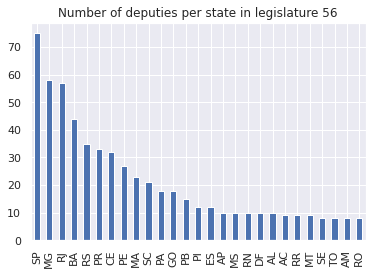

In [5]:
deputies.siglaUf.value_counts().plot.bar()
plt.title('Number of deputies per state in legislature 56')
plt.show()

In [7]:
n = 7
prop_years = np.zeros((3,n))
prop_years[0,:] = range(57-n,57)

for leg in tqdm.tqdm(prop_years[0,:].astype(int)): 
    
    deputies_F = camara.lista_deputados(legislatura=leg, sexo='F')
    deputies_M = camara.lista_deputados(legislatura=leg, sexo='M')
    
    prop_years[1,leg-50] = deputies_F.shape[0]/(deputies_F.shape[0]+deputies_M.shape[0])
    prop_years[2,leg-50] = 1 - prop_years[1,leg-50]
    
    time.sleep(3)

100%|██████████| 7/7 [00:28<00:00,  4.05s/it]


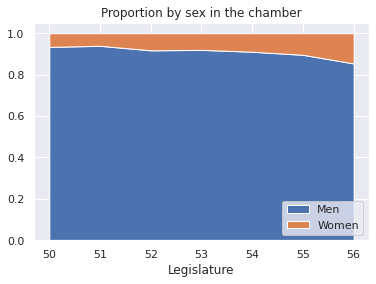

In [9]:
plt.stackplot(prop_years[0,:],  prop_years[2,:], prop_years[1,:], labels = ['Men', 'Women'])
plt.title('Proportion by sex in the chamber')
plt.legend(loc = 'lower right')
plt.xlabel('Legislature')
plt.show()

Number of parties is another important information we can get. 

In [99]:
number_parties = []

for leg in tqdm.tqdm(range(38,57)):
    
    parties_leg = camara.lista_deputados(legislatura=leg).siglaPartido.unique().shape[0]
    number_parties.append(parties_leg)
    
    time.sleep(2)

100%|██████████| 19/19 [01:02<00:00,  3.27s/it]


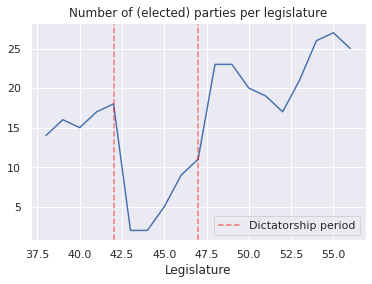

In [105]:
plt.plot(range(38,57), number_parties)
plt.axvline(42, color = 'red', alpha = 0.5, linestyle = '--', label = 'Dictatorship period')
plt.axvline(47, color = 'red', alpha = 0.5, linestyle = '--')
plt.xlabel('Legislature')
plt.title('Number of (elected) parties per legislature')
plt.legend()
plt.show()

The available information from the ddeputy is below: 

In [10]:
dep = camara.Deputado(cod=deputies.sample().iloc[0].id)
dep.dados

{'id': 74419,
 'uri': 'https://dadosabertos.camara.leg.br/api/v2/deputados/74419',
 'nomeCivil': 'LUIZ GONZAGA PATRIOTA',
 'ultimoStatus': {'id': 74419,
  'uri': 'https://dadosabertos.camara.leg.br/api/v2/deputados/74419',
  'nome': 'Gonzaga Patriota',
  'siglaPartido': 'PSB',
  'uriPartido': 'https://dadosabertos.camara.leg.br/api/v2/partidos/36832',
  'siglaUf': 'PE',
  'idLegislatura': 56,
  'urlFoto': 'https://www.camara.leg.br/internet/deputado/bandep/74419.jpg',
  'email': 'dep.gonzagapatriota@camara.leg.br',
  'data': '2019-02-01T11:45',
  'nomeEleitoral': 'Gonzaga Patriota',
  'gabinete': {'nome': '430',
   'predio': '4',
   'sala': '430',
   'andar': '4',
   'telefone': '3215-5430',
   'email': 'dep.gonzagapatriota@camara.leg.br'},
  'situacao': 'Exercício',
  'condicaoEleitoral': 'Titular',
  'descricaoStatus': None},
 'cpf': '01960970453',
 'sexo': 'M',
 'urlWebsite': None,
 'redeSocial': [],
 'dataNascimento': '1946-04-26',
 'dataFalecimento': None,
 'ufNascimento': 'PE',
 

We also can have the expenses from each deputy. Below we plot the mean expense for each party in the year 2021. 

In [164]:
deputies['expenses'] = 0
expenses_deputies = []

for deputy in tqdm.tqdm(deputies.id):
    dep = camara.Deputado(cod=deputy)
    pag = 1
    total_expenses = 0
    while True:
        
        while True: 
            try: 
                expenses = dep.despesas(ano=2021, itens=100, pagina=pag)
                break
            except: 
                time.sleep(10)
                
        if expenses.shape[0] == 0: 
            break
            
        total_expenses += expenses.valorDocumento.sum()
        pag+=1
        
    expenses_deputies.append(total_expenses)

100%|██████████| 588/588 [17:54<00:00,  1.83s/it]


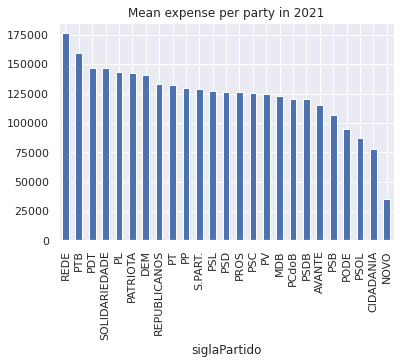

In [177]:
deputies['expenses'] = expenses_deputies

deputies.groupby(by='siglaPartido').mean().sort_values(by='expenses', ascending=False).expenses.plot.bar()
plt.title('Mean expense per party in 2021')
plt.show()

We also have access to the deputies' speeches.

In [202]:
dep = camara.Deputado(cod=deputies.sample().iloc[0].id)
print(dep.discursos(legislatura=56).transcricao.loc[0])

O SR. TADEU FILIPPELLI (MDB - DF. Pela ordem. Sem revisão do orador.) - O MDB vota "não", Sr. Presidente.
É importante entender esta MP. Na verdade, todo o sistema de segurança dos ex-Territórios é regido constitucionalmente por leis federais e fica ausente de qualquer tipo de política de aumento ou de retribuição dos seus Estados. Portanto, é fundamental que a aprovemos hoje, em função inclusive do prazo, que está expirando.


## Events

Events of Legislative Organs of the Chamber, foreseen or that have already taken place, in a certain period of time.

In [237]:
events = camara.lista_eventos(inicio='2021-01-01', fim='2021-06-30', itens=100)

In [249]:
camara.Evento(cod=events.loc[16].id).dados

{'uriDeputados': None,
 'uriConvidados': None,
 'fases': None,
 'id': 60268,
 'uri': 'https://dadosabertos.camara.leg.br/api/v2/eventos/60268',
 'dataHoraInicio': '2021-02-09T15:00',
 'dataHoraFim': '2021-02-09T21:30',
 'situacao': 'Encerrada (Final)',
 'descricaoTipo': 'Sessão Deliberativa',
 'descricao': 'Sessão Deliberativa Extraordinária (virtual)\r\n',
 'localExterno': None,
 'orgaos': [{'id': 180,
   'uri': 'https://dadosabertos.camara.leg.br/api/v2/orgaos/180',
   'sigla': 'PLEN',
   'nome': 'Plenário',
   'apelido': 'Plenário',
   'codTipoOrgao': 26,
   'tipoOrgao': 'Plenário Virtual',
   'nomePublicacao': 'Plenário'}],
 'requerimentos': [],
 'localCamara': {'nome': 'Plenário da Câmara dos Deputados',
  'predio': None,
  'sala': None,
  'andar': None},
 'urlDocumentoPauta': 'https://dadosabertos.camara.leg.br/api/v2/eventos/60268/pauta',
 'urlRegistro': 'https://www.youtube.com/watch?v=Jazms1VEHs4'}

Below we see the votings related to the event above.

In [250]:
camara.Evento(cod=events.loc[16].id).votacoes()

,id,uri,data,dataHoraRegistro,siglaOrgao,uriOrgao,uriEvento,proposicaoObjeto,uriProposicaoObjeto,descricao,aprovacao
0,2265124-39,https://dadosabertos.camara.leg.br/api/v2/vota...,2021-02-09,2021-02-09T19:24:45,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,https://dadosabertos.camara.leg.br/api/v2/even...,None,None,Rejeitado o Requerimento. Sim: 93; não: 308; t...,0
1,2265124-34,https://dadosabertos.camara.leg.br/api/v2/vota...,2021-02-09,2021-02-09T19:06:06,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,https://dadosabertos.camara.leg.br/api/v2/even...,None,None,Rejeitado o Requerimento. Sim: 101; não: 287; ...,0
2,2269481-8,https://dadosabertos.camara.leg.br/api/v2/vota...,2021-02-09,2021-02-09T18:09:42,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,https://dadosabertos.camara.leg.br/api/v2/even...,REQ 79/2021,https://dadosabertos.camara.leg.br/api/v2/prop...,Aprovado o Requerimento de Urgência (Art. 155 ...,1
3,2269480-8,https://dadosabertos.camara.leg.br/api/v2/vota...,2021-02-09,2021-02-09T16:32:45,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,https://dadosabertos.camara.leg.br/api/v2/even...,REQ 78/2021,https://dadosabertos.camara.leg.br/api/v2/prop...,Aprovado o Requerimento de Urgência (Art. 155 ...,1
4,2269049-8,https://dadosabertos.camara.leg.br/api/v2/vota...,2021-02-09,2021-02-09T16:03:11,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,https://dadosabertos.camara.leg.br/api/v2/even...,REQ 57/2021,https://dadosabertos.camara.leg.br/api/v2/prop...,Aprovado o Requerimento de Urgência (Art. 155 ...,1


## Parliamentary fronts

The parliament front is an official grouping of parliamentarians around a particular topic or proposal. It exists until the end of the legislature of creation and can be recreated afterward. There is information since the 52nd legislature. 

In [12]:
fronts = camara.lista_frentes(pagina=1).append(camara.lista_frentes(pagina=2)).reset_index(drop=True)
fronts.sample(5)

,id,uri,titulo,idLegislatura
250,53979,https://dadosabertos.camara.leg.br/api/v2/fren...,Frente Parlamentar Mista dos Consórcios Públicos,56
730,53389,https://dadosabertos.camara.leg.br/api/v2/fren...,Frente Parlamentar Mista em Defesa da Indústri...,54
378,53786,https://dadosabertos.camara.leg.br/api/v2/fren...,Frente Parlamentar Mista pela Causa da Prematu...,55
887,360,https://dadosabertos.camara.leg.br/api/v2/fren...,Frente Parlamentar Mista da Micro e Pequena Em...,54
402,53759,https://dadosabertos.camara.leg.br/api/v2/fren...,Frente Parlamentar Mista em Defesa dos Bancos ...,55


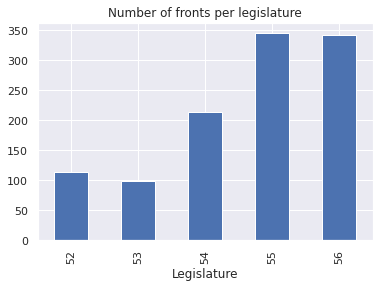

In [13]:
fronts.groupby(by='idLegislatura').count().id.plot.bar()
plt.title('Number of fronts per legislature')
plt.xlabel('Legislature')
plt.show()

The information from a specific front. 

In [14]:
front = camara.Frente(cod=fronts.sample().iloc[0].id)
front.dados

{'id': 53524,
 'uri': 'https://dadosabertos.camara.leg.br/api/v2/frentes/53524',
 'titulo': 'Frente Parlamentar em Defesa dos Agentes Comunitários de Saúde e dos Agentes de Combate às Endemias',
 'idLegislatura': 55,
 'telefone': '3215-5725',
 'email': None,
 'keywords': None,
 'idSituacao': None,
 'situacao': '17/04/2015 - Recebidos o REQ 1475/2015, a Ata, o Estatuto e as adesões.\r\n17/04/2015 - Encaminhado à SERAP para conferência de assinaturas.\r\n23/04/2015 - Foram confirmadas 227 assinaturas de Deputados. Não há Senadores.\r\n23/04/2015 - Vai à publicação.\r\n24/06/2015 - Recebido o OF 23/2015 solicitando inclusão de nova adesão.\r\n24/06/2015 - Encaminhado à SERAP para conferência de assinaturas.\r\n25/06/2015 - Confirmada 1 nova assinatura de Deputado. Não há Senadores. \r\n25/06/2015 - Vai à publicação.',
 'urlWebsite': None,
 'urlDocumento': 'https://www.camara.leg.br/internet/deputado/Frente_Parlamentar/35743-integra.pdf',
 'coordenador': {'id': 74216,
  'uri': 'https://dad

Below we can see some of the members. 

In [15]:
front.membros().sample(5)

,id,uri,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email,titulo,codTitulo,dataInicio,dataFim
142,160622,https://dadosabertos.camara.leg.br/api/v2/depu...,VICENTE CANDIDO,PT,https://dadosabertos.camara.leg.br/api/v2/part...,SP,55,https://www.camara.leg.br/internet/deputado/ba...,None,Membro,1004,None,None
43,74395,https://dadosabertos.camara.leg.br/api/v2/depu...,JOSÉ OTÁVIO GERMANO,PP,https://dadosabertos.camara.leg.br/api/v2/part...,RS,55,https://www.camara.leg.br/internet/deputado/ba...,None,Membro,1004,None,None
110,152610,https://dadosabertos.camara.leg.br/api/v2/depu...,ROBERTO ALVES,PRB,https://dadosabertos.camara.leg.br/api/v2/part...,SP,55,https://www.camara.leg.br/internet/deputado/ba...,None,Membro,1004,None,None
137,160596,https://dadosabertos.camara.leg.br/api/v2/depu...,HEULER CRUVINEL,PP,https://dadosabertos.camara.leg.br/api/v2/part...,GO,55,https://www.camara.leg.br/internet/deputado/ba...,None,Membro,1004,None,None
80,141417,https://dadosabertos.camara.leg.br/api/v2/depu...,EDIO LOPES,PR,https://dadosabertos.camara.leg.br/api/v2/part...,RR,55,https://www.camara.leg.br/internet/deputado/ba...,None,Membro,1004,None,None


In [305]:
member_distribution = []

for i in tqdm.tqdm(range(100)):
    
    for i in range(5):        
        try:     
            members = camara.Frente(cod=fronts.sample().iloc[0].id).membros().shape[0]
            break
        except: 
            time.sleep(10)
    
    member_distribution.append(members)

100%|██████████| 100/100 [09:37<00:00,  5.77s/it]


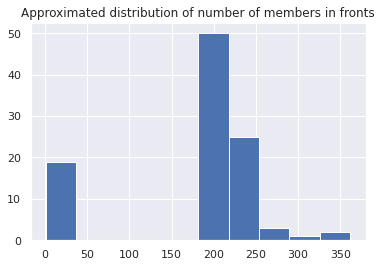

In [308]:
plt.hist(member_distribution)
plt.title('Approximated distribution of number of members in fronts')
plt.show()

## Propositions

Bills, resolutions, provisional measures, amendments, opinions and all other types of proposals in the Chamber.

In [25]:
number_props = []

for year in tqdm.tqdm(range(1993,2022)):
    
    while True: 
        try: 
            text = requests.get(api+"proposicoes?ano={}&itens=100".format(year))
            break
        except: 
            time.sleep(10)

    pagina = text.json()['links'][-1]['href'].find('pagina=')
    itens = text.json()['links'][-1]['href'].find('&itens=')
    
    last_page = int(text.json()['links'][-1]['href'][pagina+7:itens])
    
    while True: 
        try: 
            prop = camara.lista_proposicoes(ano=year, itens=100, pagina=last_page)
            break
        except: 
            time.sleep(10)
    
    number_props.append((last_page-1)*100+prop.shape[0])

100%|██████████| 29/29 [05:37<00:00, 11.64s/it]


During election year, there are less propositions when compared to the following three years. We notice that the number of propositions are growing since the beginning. 

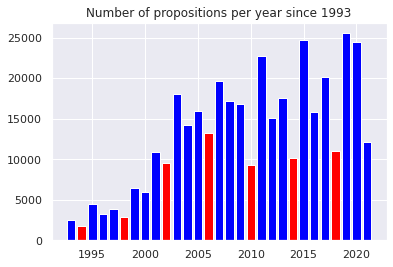

In [55]:
plt.bar(range(1993,2022), number_props, color = ['blue', 'red'] + (['blue']*3+['red'])*6 + ['blue']*3)
plt.title('Number of propositions per year since 1993')
plt.show()

The last proposition 

In [41]:
requests.get(api+'proposicoes?itens=100&dataInicio=2021-01-01&dataFim=2021-03-31').json()['links'][-1]['href']

'https://dadosabertos.camara.leg.br/api/v2/proposicoes?dataInicio=2021-01-01&dataFim=2021-03-31&pagina=136&itens=100'

In [48]:
propositions = camara.lista_proposicoes(itens=100, inicio='2021-01-01', fim='2021-03-31')

for page in tqdm.tqdm(range(2,137)): 
    
    while True: 
        try:
            props = camara.lista_proposicoes(itens=100, inicio='2021-01-01', fim='2021-03-31', pagina=page)
            break
        except: 
            time.sleep(10)
    
    propositions = propositions.append(props).reset_index(drop=True)

100%|██████████| 135/135 [02:31<00:00,  1.12s/it]


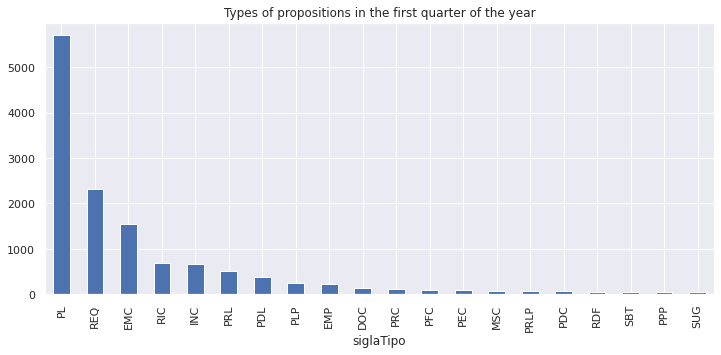

In [62]:
counts = propositions.groupby('siglaTipo').count().sort_values('id', ascending=False).id[0:20].plot.bar(figsize=(12,5))
plt.title('Types of propositions in the first quarter of the year')
plt.show()

In [76]:
#siglas = propositions.groupby('siglaTipo').count().sort_values('id', ascending=False).id[0:5]
#camara.referencias('proposicoes').set_index('sigla').loc[siglas.index]

In [86]:
prop = camara.Proposicao(cod=propositions.sample().id.iloc[0])
prop.relacionadas()

,id,uri,siglaTipo,codTipo,numero,ano,ementa
0,2221504,https://dadosabertos.camara.leg.br/api/v2/prop...,PRL,190,3,0,"Parecer da Relatora, Dep. Alê Silva (PSL-MG), ..."
1,2115341,https://dadosabertos.camara.leg.br/api/v2/prop...,PAR,187,1,0,Aprovado o Parecer por unanimidade.. \r\nParec...
2,2091011,https://dadosabertos.camara.leg.br/api/v2/prop...,PRL,190,1,0,"Parecer do Relator, Dep. Josué Bengtson (PTB-P..."
3,2110725,https://dadosabertos.camara.leg.br/api/v2/prop...,PRL,190,2,0,"Parecer do Relator, Dep. Josué Bengtson (pende..."
4,2113408,https://dadosabertos.camara.leg.br/api/v2/prop...,PRL,190,3,0,"Parecer do Relator, Dep. Josué Bengtson (PTB-P..."
5,2208996,https://dadosabertos.camara.leg.br/api/v2/prop...,PAR,187,1,0,"Aprovado o Parecer do Relator, Deputado Wellin..."
6,2204948,https://dadosabertos.camara.leg.br/api/v2/prop...,PRL,190,2,0,"Parecer do Relator, Dep. Wellington Roberto (P..."
7,2204950,https://dadosabertos.camara.leg.br/api/v2/prop...,SBT,255,1,0,Torna obrigatória a contratação de seguro cont...
8,2053637,https://dadosabertos.camara.leg.br/api/v2/prop...,REQ,392,3514,2015,Requer urgência para apreciação do Projeto de ...
9,2056372,https://dadosabertos.camara.leg.br/api/v2/prop...,REQ,305,3606,2015,Requer a desapensação do Projeto de Lei nº 356...


In [87]:
prop.temas()

,codTema,tema,relevancia
0,54,"Energia, Recursos Hídricos e Minerais",0


In [91]:
prop.tramitacoes()[prop.tramitacoes().siglaOrgao=='PLEN'].shape[0]

41

In [92]:
prop.votacoes()

,id,uri,data,dataHoraRegistro,siglaOrgao,uriOrgao,uriEvento,proposicaoObjeto,uriProposicaoObjeto,descricao,aprovacao
0,2053378-124,https://dadosabertos.camara.leg.br/api/v2/vota...,2019-06-12,2019-06-12T15:21:10,CME,https://dadosabertos.camara.leg.br/api/v2/orga...,https://dadosabertos.camara.leg.br/api/v2/even...,None,None,"Aprovado o Parecer do Relator, Deputado Wellin...",1
1,2053378-88,https://dadosabertos.camara.leg.br/api/v2/vota...,2016-10-25,2016-10-25T12:03:47,CMADS,https://dadosabertos.camara.leg.br/api/v2/orga...,https://dadosabertos.camara.leg.br/api/v2/even...,None,None,Aprovado o Parecer por unanimidade.,1
2,2053378-42,https://dadosabertos.camara.leg.br/api/v2/vota...,2016-03-31,2016-03-31T14:40:57,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,https://dadosabertos.camara.leg.br/api/v2/even...,None,None,** Aprovado o Requerimento do Dep. Paulo Teixe...,1
3,2053378-39,https://dadosabertos.camara.leg.br/api/v2/vota...,2016-03-30,2016-03-30T15:55:31,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,https://dadosabertos.camara.leg.br/api/v2/even...,None,None,**Aprovado o Requerimento do Dep. José Guimarã...,1
4,2053378-35,https://dadosabertos.camara.leg.br/api/v2/vota...,2016-03-23,2016-03-23T11:41:55,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,https://dadosabertos.camara.leg.br/api/v2/even...,None,None,*** Aprovado o Requerimento do Dep. Onyx Loren...,1
5,2053378-33,https://dadosabertos.camara.leg.br/api/v2/vota...,2016-03-22,2016-03-22T13:25:04,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,None,None,None,Alteração do Regime de Tramitação desta propos...,1


In [103]:
camara.Votacao(cod="2053378-42").votos()

""


## Votings 

Basic information about the votes that took place in events of the different bodies of the Chamber. 

In [31]:
page = requests.get(api+'votacoes?dataInicio=2021-01-01&dataFim=2021-06-30&itens=200')
page.json()['links'][-1]['href']

'https://dadosabertos.camara.leg.br/api/v2/votacoes?dataInicio=2021-01-01&dataFim=2021-06-30&pagina=18&itens=200'

In [32]:
votings = camara.lista_votacoes(inicio='2021-01-01', fim='2021-06-30')

for page in tqdm.tqdm(range(2,19)):
    
    while True: 
        try:   
            votings = votings.append(camara.lista_votacoes(inicio='2021-01-01', fim='2021-06-30', pagina=page))
            break
        except: 
            time.sleep(10)

100%|██████████| 17/17 [07:31<00:00, 26.53s/it]


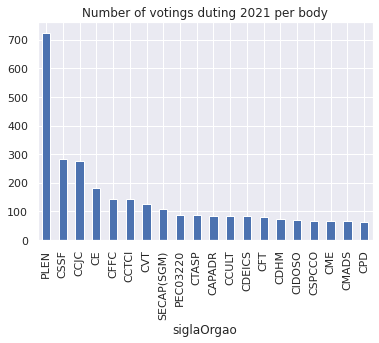

In [41]:
votings.groupby('siglaOrgao').id.count().sort_values(ascending=False).iloc[0:20].plot.bar()
plt.title('Number of votings duting 2021 per body')
plt.show()

In [49]:
vot = camara.Votacao(cod=votings[votings.siglaOrgao=='PLEN'].sample().id.iloc[0])

In [52]:
vot.dados.keys()

dict_keys(['id', 'uri', 'data', 'dataHoraRegistro', 'siglaOrgao', 'uriOrgao', 'idOrgao', 'uriEvento', 'idEvento', 'descricao', 'aprovacao', 'descUltimaAberturaVotacao', 'dataHoraUltimaAberturaVotacao', 'ultimaApresentacaoProposicao', 'efeitosRegistrados', 'objetosPossiveis', 'proposicoesAfetadas'])

In [63]:
vot.dados['proposicoesAfetadas']

[{'id': 2263719,
  'uri': 'https://dadosabertos.camara.leg.br/api/v2/proposicoes/2263719',
  'siglaTipo': 'MPV',
  'codTipo': 291,
  'numero': 1006,
  'ano': 2020,
  'ementa': 'Aumenta a margem de crédito consignado dos titulares de benefícios de aposentadoria e pensão do Regime Geral de Previdência Social durante o período da pandemia de covid-19.  NOVA EMENTA: Dispõe sobre o acréscimo de 5% (cinco por cento) ao percentual máximo para a contratação de operações de crédito com desconto automático em folha de pagamento no período de calamidade pública decorrente da pandemia da Covid-19; e altera a Lei nº 8.213, de 24 de julho de 1991.'}]